# Run QSVR experiments with multiple splits

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint, random
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import neal #import to use simulated annealing sampler
from dwave.system import LazyFixedEmbeddingComposite, DWaveSampler #import to select specific sampler
from scipy.stats import loguniform

In [3]:
search_svr_hps = True
experiment_name = 'eric_params_chain_strength_hp_search'
save = True
#date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")
#experiment_name = experiment_name + date

### Run experiments with fixed epsilon, C and gamma

In [4]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if search_svr_hps: #ONLY RUNS FOR FIXED SVR PARAMS: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to True')

# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 10
r2 = np.zeros((num_runs, 7))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train = X_train[:79,:]
	y_train = y_train[:79]
	
	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	qsvr_model.fit(X_train, y_train,
			K = 3, B = 0.5,
			epsilon = 0.02, k0 = 0.005,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=40,
			gamma=0.1, C=67.61,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(7):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]} with mean = {r2[i,:].mean()}')

results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5],
	'min energy' : r2[:,6]
}

dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

2022-08-23 13:51:51,511 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 13:51:51,646 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 13:51:51,647 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 13:51:51,648 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'
2022-08-23 13:51:53,586 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 13:51:53,644 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 13:51:53,645 dwave.cloud.client.base INFO MainThread Filtere

best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.00833333 0.025      0.05       0.04166667 0.         0.01666667
 0.00833333 0.03333333 0.         0.05833333 0.03333333 0.00833333
 0.025      0.01666667 0.04166667 0.025      0.00833333 0.025
 0.01666667 0.025      0.00833333 0.         0.03333333 0.025
 0.04166667 0.04166667 0.00833333 0.01666667 0.025      0.00833333
 0.025      0.05833333 0.025      0.03333333 0.025      0.03333333
 0.03333333 0.01666667 0.06666667 0.01666667 0.01666667 0.025
 0.01666667 0.         0.025      0.03333333 0.025      0.03333333
 0.05833333 0.025      0.04166667 0.03333333 0.03333333 0.03333333
 0.03333333 0.04166667 0.025      0.025      0.04166667 0.01666667
 0.00833333 0.025      0.00833333 0.01666667 0.03333333 0.025
 0.00833333 0.00833333 0.01666667 0.01666667 0.025      0.00

2022-08-23 13:54:39,038 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 13:54:39,068 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 13:54:39,071 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 13:54:39,072 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 0 with r2 = [0.86399326 0.79275513 0.863527   0.84029906 0.79261252 0.82657031
 0.79261252] with mean = 0.8246242585393299


2022-08-23 13:54:40,718 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 13:54:40,785 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 13:54:40,786 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.03333333 0.025      0.05833333 0.05833333 0.03333333 0.04166667
 0.09166667 0.075      0.05       0.03333333 0.03333333 0.04166667
 0.03333333 0.05       0.025      0.03333333 0.05       0.06666667
 0.04166667 0.05       0.025      0.06666667 0.075      0.025
 0.05       0.06666667 0.025      0.05833333 0.01666667 0.04166667
 0.05833333 0.05833333 0.05       0.05       0.04166667 0.075
 0.03333333 0.05833333 0.05833333 0.04166667 0.06666667 0.01666667
 0.03333333 0.075      0.04166667 0.03333333 0.05       0.03333333
 0.075      0.05       0.08333333 0.01666667 0.1        0.03333333
 0.05       0.01666667 0.04166667 0.05       0.09166667 0.05833333
 0.06666667 0.075      0.04166667 0.08333333 0.075      0.075
 0.08333333 0.04166667 0.05833333 0.075      0.05      

2022-08-23 13:58:58,975 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 13:58:59,017 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 13:58:59,018 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 13:58:59,020 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 1 with r2 = [0.8946452  0.89091047 0.89467263 0.89011161 0.89946829 0.88360819
 0.73679803] with mean = 0.8700306307539023


2022-08-23 13:59:00,536 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 13:59:00,592 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 13:59:00,593 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.01666667 0.025      0.04166667 0.01666667 0.025      0.025
 0.04166667 0.00833333 0.03333333 0.         0.00833333 0.03333333
 0.01666667 0.05       0.00833333 0.04166667 0.01666667 0.025
 0.06666667 0.025      0.01666667 0.01666667 0.         0.01666667
 0.03333333 0.00833333 0.025      0.04166667 0.00833333 0.00833333
 0.04166667 0.03333333 0.04166667 0.04166667 0.04166667 0.03333333
 0.04166667 0.025      0.00833333 0.03333333 0.05833333 0.00833333
 0.025      0.025      0.04166667 0.05       0.01666667 0.01666667
 0.01666667 0.025      0.025      0.025      0.01666667 0.01666667
 0.025      0.00833333 0.         0.01666667 0.025      0.06666667
 0.01666667 0.01666667 0.025      0.01666667 0.025      0.04166667
 0.01666667 0.03333333 0.01666667 0.04166667 0.025

2022-08-23 14:03:22,513 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:03:22,548 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:03:22,550 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:03:22,552 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 2 with r2 = [0.91499561 0.91477879 0.91497539 0.91478653 0.91477879 0.87513726
 0.69600021] with mean = 0.8779217964310302


2022-08-23 14:03:24,045 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:03:24,116 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:03:24,117 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.025      0.00833333 0.03333333 0.01666667 0.00833333 0.03333333
 0.04166667 0.00833333 0.05       0.01666667 0.04166667 0.01666667
 0.025      0.05       0.         0.05833333 0.03333333 0.01666667
 0.025      0.025      0.03333333 0.03333333 0.01666667 0.03333333
 0.00833333 0.00833333 0.03333333 0.05       0.025      0.03333333
 0.025      0.05       0.01666667 0.03333333 0.         0.03333333
 0.04166667 0.04166667 0.025      0.025      0.03333333 0.01666667
 0.09166667 0.04166667 0.025      0.025      0.03333333 0.04166667
 0.         0.04166667 0.03333333 0.03333333 0.05       0.04166667
 0.04166667 0.04166667 0.04166667 0.025      0.03333333 0.01666667
 0.05833333 0.05833333 0.04166667 0.         0.04166667 0.03333333
 0.00833333 0.03333333 0.00833333 0.025 

2022-08-23 14:08:51,474 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:08:51,508 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:08:51,510 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:08:51,511 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 3 with r2 = [ 0.50768732  0.82380434  0.48523434  0.56385224  0.80857902 -0.86787273
  0.80857902] with mean = 0.4471233642265834


2022-08-23 14:08:53,838 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:08:53,902 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:08:53,904 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.01666667 0.         0.01666667 0.00833333 0.05       0.025
 0.         0.025      0.05       0.025      0.025      0.01666667
 0.025      0.03333333 0.04166667 0.01666667 0.03333333 0.00833333
 0.06666667 0.01666667 0.01666667 0.025      0.025      0.05
 0.03333333 0.075      0.025      0.01666667 0.03333333 0.01666667
 0.025      0.01666667 0.01666667 0.00833333 0.04166667 0.01666667
 0.01666667 0.03333333 0.025      0.00833333 0.03333333 0.025
 0.01666667 0.04166667 0.03333333 0.01666667 0.01666667 0.03333333
 0.04166667 0.05       0.00833333 0.03333333 0.025      0.01666667
 0.01666667 0.03333333 0.05       0.025      0.03333333 0.03333333
 0.025      0.025      0.025      0.00833333 0.01666667 0.00833333
 0.04166667 0.05833333 0.05       0.01666667 0.05       

2022-08-23 14:10:31,985 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:10:32,055 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:10:32,057 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:10:32,058 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 4 with r2 = [0.89727896 0.90088959 0.89724903 0.9008068  0.90088959 0.88758098
 0.81855067] with mean = 0.8861779441766753


2022-08-23 14:10:33,518 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:10:33,578 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:10:33,579 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.01666667 0.025      0.03333333 0.04166667 0.06666667 0.03333333
 0.025      0.03333333 0.04166667 0.025      0.00833333 0.03333333
 0.01666667 0.025      0.03333333 0.05       0.03333333 0.025
 0.04166667 0.04166667 0.04166667 0.03333333 0.03333333 0.05
 0.04166667 0.01666667 0.05833333 0.00833333 0.03333333 0.00833333
 0.06666667 0.025      0.025      0.01666667 0.025      0.03333333
 0.03333333 0.03333333 0.025      0.         0.01666667 0.04166667
 0.00833333 0.04166667 0.06666667 0.03333333 0.075      0.05833333
 0.01666667 0.025      0.03333333 0.00833333 0.04166667 0.03333333
 0.03333333 0.01666667 0.04166667 0.05       0.03333333 0.05
 0.04166667 0.03333333 0.05833333 0.05       0.04166667 0.025
 0.075      0.025      0.03333333 0.00833333 0.04166667 0.0583

2022-08-23 14:14:01,718 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:14:01,765 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:14:01,766 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:14:01,767 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 5 with r2 = [0.88534036 0.88599404 0.88520238 0.88753726 0.88599404 0.85602011
 0.88599404] with mean = 0.8817260335008026


2022-08-23 14:14:04,000 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:14:04,051 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:14:04,052 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.03333333 0.05       0.04166667 0.025      0.05833333 0.025
 0.03333333 0.04166667 0.06666667 0.03333333 0.05       0.025
 0.01666667 0.03333333 0.01666667 0.04166667 0.05       0.04166667
 0.025      0.03333333 0.075      0.05       0.025      0.025
 0.04166667 0.06666667 0.04166667 0.05833333 0.025      0.05833333
 0.05       0.05       0.04166667 0.075      0.03333333 0.03333333
 0.03333333 0.05       0.06666667 0.05       0.01666667 0.075
 0.05833333 0.04166667 0.05833333 0.05       0.04166667 0.03333333
 0.04166667 0.025      0.06666667 0.025      0.025      0.05
 0.00833333 0.01666667 0.05833333 0.06666667 0.03333333 0.03333333
 0.03333333 0.06666667 0.05       0.06666667 0.04166667 0.
 0.025      0.025      0.04166667 0.05       0.01666667 0.025
 0.03333333 

2022-08-23 14:18:48,202 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:18:48,268 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:18:48,270 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:18:48,272 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 6 with r2 = [0.82906551 0.86615139 0.82852897 0.86985182 0.86278059 0.77087377
 0.77799895] with mean = 0.8293215702142802


2022-08-23 14:18:49,799 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:18:49,874 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:18:49,876 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.01666667 0.05       0.025      0.04166667 0.025      0.01666667
 0.03333333 0.025      0.00833333 0.01666667 0.00833333 0.03333333
 0.01666667 0.05833333 0.00833333 0.01666667 0.04166667 0.03333333
 0.025      0.05833333 0.03333333 0.00833333 0.03333333 0.05833333
 0.03333333 0.05       0.05833333 0.025      0.04166667 0.025
 0.025      0.04166667 0.04166667 0.025      0.04166667 0.03333333
 0.05833333 0.04166667 0.025      0.05       0.03333333 0.03333333
 0.04166667 0.025      0.025      0.05       0.025      0.05
 0.025      0.025      0.03333333 0.05       0.05833333 0.01666667
 0.05       0.03333333 0.03333333 0.06666667 0.01666667 0.03333333
 0.06666667 0.03333333 0.05       0.01666667 0.04166667 0.04166667
 0.01666667 0.03333333 0.04166667 0.03333333 0.0416

2022-08-23 14:24:33,207 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:24:33,344 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:24:33,345 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:24:33,346 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 7 with r2 = [0.84128781 0.92162426 0.84029032 0.91697071 0.92314056 0.64672655
 0.39250876] with mean = 0.7832212813617975


2022-08-23 14:24:36,161 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:24:36,219 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:24:36,221 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.04166667 0.04166667 0.03333333 0.04166667 0.03333333 0.00833333
 0.03333333 0.05833333 0.01666667 0.03333333 0.00833333 0.00833333
 0.00833333 0.025      0.025      0.025      0.04166667 0.05833333
 0.06666667 0.05       0.025      0.025      0.04166667 0.04166667
 0.08333333 0.00833333 0.01666667 0.05       0.025      0.01666667
 0.05       0.03333333 0.025      0.04166667 0.04166667 0.06666667
 0.05833333 0.03333333 0.025      0.05       0.03333333 0.025
 0.04166667 0.         0.03333333 0.03333333 0.00833333 0.01666667
 0.01666667 0.00833333 0.04166667 0.03333333 0.03333333 0.00833333
 0.06666667 0.03333333 0.05       0.         0.03333333 0.04166667
 0.025      0.01666667 0.05       0.04166667 0.01666667 0.025
 0.04166667 0.025      0.03333333 0.00833333 0.025

2022-08-23 14:28:40,182 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-23 14:28:40,226 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-23 14:28:40,229 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={'name__eq': 'Advantage_system6.1'}, order_by='avg_load'
2022-08-23 14:28:40,231 dwave.cloud.client.base INFO MainThread Fetching definition of a solver with name='Advantage_system6.1'


Finished run 8 with r2 = [0.91739894 0.921177   0.91735735 0.921177   0.921177   0.87976055
 0.7738701 ] with mean = 0.8931311312537449


2022-08-23 14:28:41,862 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-23 14:28:41,913 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system6.1')
2022-08-23 14:28:41,921 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system6.1')]


best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers
[0.09166667 0.05       0.075      0.03333333 0.05833333 0.05
 0.05       0.06666667 0.05833333 0.         0.025      0.05833333
 0.04166667 0.00833333 0.00833333 0.05       0.00833333 0.04166667
 0.075      0.01666667 0.025      0.05       0.04166667 0.025
 0.06666667 0.03333333 0.01666667 0.04166667 0.05       0.00833333
 0.03333333 0.025      0.05       0.03333333 0.         0.05
 0.04166667 0.05       0.03333333 0.025      0.06666667 0.00833333
 0.05833333 0.04166667 0.05       0.01666667 0.03333333 0.04166667
 0.04166667 0.05       0.04166667 0.05       0.01666667 0.025
 0.05       0.03333333 0.025      0.05       0.05833333 0.04166667
 0.05833333 0.025      0.025      0.025      0.06666667 0.03333333
 0.04166667 0.05       0.04166667 0.03333333 0.05       0.05
 

### Run experiments searching for epsilon, C and gamma

In [37]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
if not search_svr_hps: #ONLY RUNS if user wants to search for: epsilon, C and gamma
	nb_utils.exit_cell('Exiting cell as search_svr_hps is set to False')
	
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = randint(0, 2**30)
num_runs = 5
r2 = np.zeros((num_runs, 6))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=rs+i)

	# Optimiza SVR hps using classical SVR
	best, C_best, epsilon_best, gamma_best = -100, None, None, None
	for j in range(5000):
		C = loguniform(1e0,1e3)
		gamma = loguniform(1e-5,10)
		epsilon = loguniform(1e-3,1e0)
		model = SVR(C=C,epsilon=epsilon,gamma=gamma)
		cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=rs+j)
		cvs = cvs.mean()
		if best < cvs:
			best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
	
	B = 0.5
	K = 3
	k0 = 0.005
	exponents_array = np.array(list(range(K)))
	exponents_array = exponents_array-k0
	C_min = sum(np.power(B, exponents_array))
	
	if (C_best < C_min): 
		C_best = C_min
			
	print(pd.DataFrame({'CV mean R^2': best, 'C': C_best, 'epsilon': epsilon_best, 'gamma': gamma_best}, index=['Best hyperparameters']))

	X_train, _, y_train, _ = train_test_split(X, y, train_size=20, random_state=rs+i)

	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	#set sampler
	sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
	qsvr_model.fit(X_train, y_train,
			K = K, B = B,
			epsilon = epsilon_best, k0 = k0,
			xi=0.01, n_samples = 20, num_reads = 1000,
			random_seed=rs+i,
			n_samples_for_gamma_and_C_optimizations=40,
			gamma=gamma_best, C=C_best,
			use_custom_chainstrength=True,
			chain_mult=8,
			sampler=sampler)
	
	if save: nb_utils.save_qsvr(qsvr_model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)) # save QSVR for further predictions
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(6):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]}')
results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5]
}

if save: dump(results, 'results_'+experiment_name+'_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

Exiting cell as search_svr_hps is set to False


### Analize experiment results

All r2 metrics:
mean = 0.8169138586238973 
max = 0.9231405561602681 
min = -0.8678727299258415 
median = 0.8789609240557077 
std = 0.22774754465508745


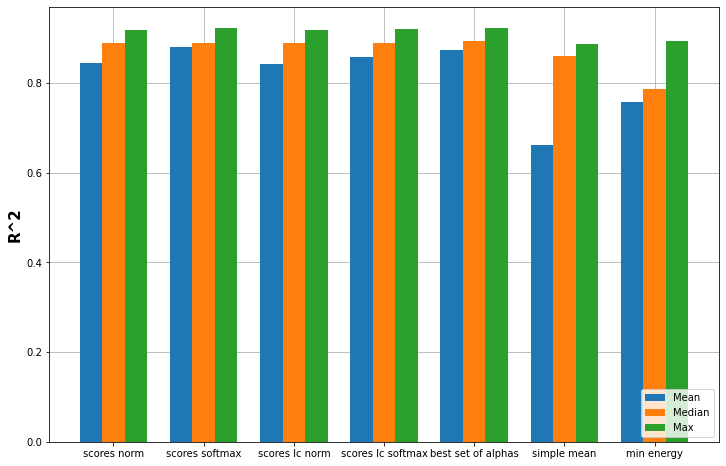

In [5]:
all_r2 = r2.flatten()
print(f'All r2 metrics:\nmean = {all_r2.mean()} \nmax = {all_r2.max()} \nmin = {all_r2.min()} \nmedian = {np.median(all_r2)} \nstd = {all_r2.std()}')


#results = load('results_B10_g01_k005_xi01_c67_rs'+str(rs)+'.joblib')
barWidth = 0.25

fig = plt.subplots(figsize =(12, 8))
plt.grid()
plt.gca().set_axisbelow(True)
 
# set height of bar
#MIN = [val.min() for val in results.values()]
MEAN = [val.mean() for val in results.values()]
MEDIAN = [np.median(val) for val in results.values()]
MAX = [val.max() for val in results.values()]
 
# Set position of bar on X axis
br1 = np.arange(len(results))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, MEAN, width = barWidth, label ='Mean')
plt.bar(br2, MEDIAN, width = barWidth, label ='Median')
plt.bar(br3, MAX, width = barWidth, label ='Max')

# Adding Xticks
plt.ylabel('R^2', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(results.keys()))], list(results.keys()))
 
plt.legend(loc = 'lower right')
plt.show()

In [15]:
summary = pd.DataFrame(columns = ['method', 'min', 'max', 'mean', 'median', 'std'])
for k in results.keys():
    summary.loc[len(summary.index)] =[k,
        results[k].min(),
        results[k].max(),
        results[k].mean(),
        np.median(results[k]),
        results[k].std()]
print(summary)

               method       min       max      mean    median       std
0         scores norm  0.507687  0.917399  0.844659  0.889993  0.115699
1      scores softmax  0.792755  0.921624  0.879310  0.888452  0.040262
2      scores lc norm  0.485234  0.917357  0.842206  0.889938  0.122245
3   scores lc softmax  0.563852  0.921177  0.858355  0.888824  0.100902
4  best set of alphas  0.792613  0.923141  0.874121  0.892731  0.045421
5         simple mean -0.867873  0.887581  0.662050  0.859056  0.514801
6          min energy  0.392509  0.894055  0.757697  0.785306  0.134478


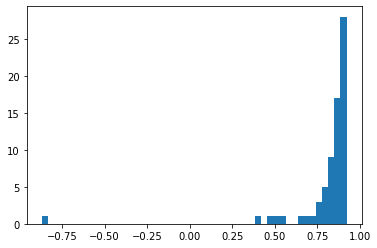

In [9]:
plt.hist(r2.flatten(),bins=50)
plt.show()